# Noise

author: laquitainesteeve@gmail.com

Validation of trace noise.

Execution time: 10 secs

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

Resources required: 
- more than 180 GB RAM

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"
4. Update noise data paths in ./conf/ and pre-compute with multi-node processing: "_src/pipes/validation/noise/mpi_dense_full.py_"

In [ ]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing
import torch
import spikeinterface as si
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# spikebias package
from src.nodes.utils import standardize_layers
from src.nodes.validation import noise

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SF_V = 20000          # sampling frequency
SF_S = 20000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad
GAIN_TO_UV = 0.195 # as in described in Horvath 2021 paper

# setup recording paths
RAW_PATH_hs_p1 = "dataset/00_raw/recording_dense_probe1"
RAW_PATH_hs_p2 = "dataset/00_raw/recording_dense_probe2"
RAW_PATH_hs_p3 = "dataset/00_raw/recording_dense_probe3"
RAW_PATH_hv_p1 = "dataset/00_raw/recording_horvath_probe1"
RAW_PATH_hv_p2 = "dataset/00_raw/recording_horvath_probe2"
RAW_PATH_hv_p3 = "dataset/00_raw/recording_horvath_probe3"

# setup noise dataset paths
NOISE_PATH_hs_p1 = "dataset/01_intermediate/noise/dense_probe1"
NOISE_PATH_hs_p2 = "dataset/01_intermediate/noise/dense_probe2"
NOISE_PATH_hs_p3 = "dataset/01_intermediate/noise/dense_probe3"
NOISE_PATH_hv_p1 = "dataset/01_intermediate/noise/horvath_probe1"
NOISE_PATH_hv_p2 = "dataset/01_intermediate/noise/horvath_probe2"
NOISE_PATH_hv_p3 = "dataset/01_intermediate/noise/horvath_probe3"

# pipeline parameters
SAVE_FIG = False
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

# intermediate data path
PLOT_DATA_PATH = "dataset/01_intermediate/statistics/fig2p_data_noise_dense.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.4)
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255 # green

cl = dict()
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

### Specs

In [6]:
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())

available cpus: 72
available gpus: True


### (8m)Load noise data

* for 10 minutes of recording (45 mins)
* pytorch implementation (8min) of mean absolute deviation is 7 times faster than pandas (45m).

In [ ]:
# load
plot_data_v1 = pd.read_csv(NOISE_PATH_hv_p1)
plot_data_v2 = pd.read_csv(NOISE_PATH_hv_p2)
plot_data_v3 = pd.read_csv(NOISE_PATH_hv_p3)

plot_data_s1 = pd.read_csv(NOISE_PATH_hs_p1)
plot_data_s2 = pd.read_csv(NOISE_PATH_hs_p2)
plot_data_s3 = pd.read_csv(NOISE_PATH_hs_p3)

# select relevant data
plot_data_s1 = plot_data_s1[["noise", "layer", "experiment"]]
plot_data_s2 = plot_data_s2[["noise", "layer", "experiment"]]
plot_data_s3 = plot_data_s3[["noise", "layer", "experiment"]]

# select L4 and L5 from probe 2
plot_data_v2 = plot_data_v2[
    (plot_data_v2["layer"] == "L4") | (plot_data_v2["layer"] == "L5")
]

# select L4 and L5 from probe 2
plot_data_s2 = plot_data_s2[np.isin(plot_data_s2["layer"], ["L4", "L5"])]

# unit-test
assert plot_data_v1["layer"].unique().tolist() == ["L1", "L2_3"], "wrong layers"
assert plot_data_v2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert plot_data_v3["layer"].unique().tolist() == ["L6"], "wrong layers"
assert plot_data_s1["layer"].unique().tolist() == ["L1", "L2_3"], "wrong layers"
assert plot_data_s2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert plot_data_s3["layer"].unique().tolist() == ["L6"], "wrong layer"

# stack
plot_data = pd.concat(
    [
        plot_data_v1,
        plot_data_v2,
        plot_data_v3,
        plot_data_s1,
        plot_data_s2,
        plot_data_s3,
    ],
    ignore_index=True,
)

# standardize names
plot_data["experiment"][plot_data["experiment"] == "vivo"] = "Dense probe (Horvath)"
plot_data["experiment"][
    plot_data["experiment"] == "silico"
] = "Dense probe (biophy. spont.)"

# standardize layer 2/3
plot_data["layer"][plot_data["layer"] == "L2"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L3"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L2_3"] = "L2/3"

In [10]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_data.to_parquet(PLOT_DATA_PATH)
    print("Saved here:", PLOT_DATA_PATH)
elif LOAD_TEMP_DATA:
    plot_data = pd.read_parquet(PLOT_DATA_PATH)

# scale gain to uV
plot_data['noise'] = plot_data['noise'].values * GAIN_TO_UV # scale to uV

plot_data

,Unnamed: 0,noise,layer,experiment
0,32.0,4.177475,L1,Dense probe (Horvath)
1,52.0,4.024860,L1,Dense probe (Horvath)
2,53.0,4.014531,L1,Dense probe (Horvath)
3,54.0,4.091912,L1,Dense probe (Horvath)
4,55.0,4.031500,L1,Dense probe (Horvath)
...,...,...,...,...
564,NaN,5.569744,L6,Dense probe (biophy. spont.)
565,NaN,5.584815,L6,Dense probe (biophy. spont.)
566,NaN,5.456265,L6,Dense probe (biophy. spont.)
567,NaN,5.580154,L6,Dense probe (biophy. spont.)


## Layers per depth (model vs. vivo) 

In [11]:
def print_layer_set(exp, cfg):
    print(
        exp,
        np.unique(
            si.load_extractor(cfg["probe_wiring"]["output"]).get_property("layers")
        ),
    )

In [16]:
# print_layer_set("hv1:", data_conf_hv_p1)
# print_layer_set("hs1:", data_conf_hs_p1)

# print_layer_set("hv2:", data_conf_hv_p2)
# print_layer_set("hs2:", data_conf_hs_p2)

# print_layer_set("hv3:", data_conf_hv_p3)
# print_layer_set("hs3:", data_conf_hs_p3)

### Plot

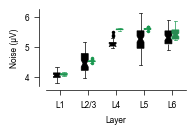

In [16]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=["Dense probe (Horvath)", "Dense probe (biophy. spont.)"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# labels
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_HV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (HV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (HS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save figures
if SAVE_FIG:
    plt.savefig(    
        "figures/0_validation/3_noise/fig2P/fig2P_noise_denser.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Statistical tests

### Noise level changes across layers?

In [17]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record
    
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
print("\n--------------------H--------------------\n")
noise.get_kk(plot_data, "Dense probe (Horvath)")
display(noise.get_posthoc_dunn_holm_sidak(plot_data, "Dense probe (Horvath)"))
m_h = get_medians_and_ci95(plot_data, "Dense probe (Horvath)", "noise")

print("\n--------------------DS--------------------\n")
noise.get_kk(plot_data, "Dense probe (biophy. spont.)")
noise.get_posthoc_dunn_holm_sidak(plot_data, "Dense probe (biophy. spont.)")
m_ds = get_medians_and_ci95(plot_data, "Dense probe (biophy. spont.)", "noise")


--------------------H--------------------

H=175.52139986119232, p=6.82704885032333e-37
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.147452e-02,5.984886e-09,9.654362e-22,2.639376e-25
L2/3,1.147452e-02,1.000000e+00,1.549393e-04,3.314816e-14,1.083038e-17
L4,5.984886e-09,1.549393e-04,1.000000e+00,3.410051e-01,1.627195e-01
L5,9.654362e-22,3.314816e-14,3.410051e-01,1.000000e+00,2.353189e-01
L6,2.639376e-25,1.083038e-17,1.627195e-01,2.353189e-01,1.000000e+00


4.0643 $\pm$ 0.038739, 4.4592 $\pm$ 0.078633, 5.0682 $\pm$ 0.06442, 5.2662 $\pm$ 0.083329, 5.3095 $\pm$ 0.061742, 

--------------------DS--------------------

H=232.14160227236243, p=4.566044574016996e-49
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites
4.0904 $\pm$ 0.011425, 4.5312 $\pm$ 0.006534, 5.5924 $\pm$ 0.007626, 5.5993 $\pm$ 0.004845, 5.4059 $\pm$ 0.038792, 


## Are Models and in vivo data the same?

In [18]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_noise(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["noise"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_noise(df, "Dense probe (Horvath)", layer),
        get_noise(df, "Dense probe (biophy. spont.)", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "Dense probe (Horvath)", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "Dense probe (biophy. spont.)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Dense probe (Horvath)", layer),
        get_noise(plot_data, "Dense probe (biophy. spont.)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    df.index = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    return df


def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Dense probe (Horvath)", layer),
        get_noise(plot_data, "Dense probe (biophy. spont.)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    df.index = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    return df

In [ ]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))

print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=3.274409544679827, p=0.070368243893953
N_H = 36 sites
N_DS = 37 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.070368
Dense probe (biophy. spont.),0.070368,1.000000



------LAYER 2/3:------

H=3.150624999999934, p=0.07589788718738133
N_H = 60 sites
N_DS = 64 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.075898
Dense probe (biophy. spont.),0.075898,1.000000



------LAYER 4:------

H=36.226415094339615, p=1.7567319179177604e-09
N_H = 20 sites
N_DS = 32 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000e+00,1.756732e-09
Dense probe (biophy. spont.),1.756732e-09,1.000000e+00



------LAYER 5:------

H=52.55025213615352, p=4.1937890383532494e-13
N_H = 88 sites
N_DS = 88 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000e+00,4.193789e-13
Dense probe (biophy. spont.),4.193789e-13,1.000000e+00



------LAYER 6:------

H=5.900218853421563, p=0.015139003557657727
N_H = 68 sites
N_DS = 76 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.015139
Dense probe (biophy. spont.),0.015139,1.000000


### MANN-WHITNEY: Model and data noise are the same - no

In [19]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(
    plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L2/3"
)

print("\nlayer 4\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L6")


layer 1

1 vs. 2, z=502.0, p=0.07107643334982655, N_1=36, N_2=37

layer 2/3

1 vs. 2, z=1565.0, p=0.07626045115090274, N_1=60, N_2=64

layer 4

1 vs. 2, z=0.0, p=1.5873692659979667e-14, N_1=20, N_2=32

layer 5

1 vs. 2, z=1422.0, p=2.5110639219655938e-14, N_1=88, N_2=88

layer 6

1 vs. 2, z=1977.0, p=0.014909479384037909, N_1=68, N_2=76


## Summary statistics

In [20]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

L1 = pc(m_h[0], m_ds[0])

L23 = pc(m_h[1], m_ds[1])

L4 = pc(m_h[2], m_ds[2])

L5 = pc(m_h[3], m_ds[3])

L6 = pc(m_h[4], m_ds[4])

print("Models median noise are on average ", - np.round(np.median([L1, L23, L4, L5, L6]),1), "% Marques-Smith data")

Models median noise are on average  1.8 % Marques-Smith data
